# Common imports

In [19]:
%matplotlib inline
import os
import sys
import glob
import re
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
import timeit

# Provided functions
### Image loading and saving

In [20]:
def LoadFaceImages(pathname, subject_name, num_images):
    """
    Load the set of face images.  
    The routine returns
        ambimage: image illuminated under the ambient lighting
        imarray: a 3-D array of images, h x w x Nimages
        lightdirs: Nimages x 3 array of light source directions
    """

    def load_image(fname):
        return np.asarray(Image.open(fname))

    def fname_to_ang(fname):
        yale_name = os.path.basename(fname)
        return int(yale_name[12:16]), int(yale_name[17:20])

    def sph2cart(az, el, r):
        rcos_theta = r * np.cos(el)
        x = rcos_theta * np.cos(az)
        y = rcos_theta * np.sin(az)
        z = r * np.sin(el)
        return x, y, z

    ambimage = load_image(
        os.path.join(pathname, subject_name + '_P00_Ambient.pgm'))
    im_list = glob.glob(os.path.join(pathname, subject_name + '_P00A*.pgm'))
    if num_images <= len(im_list):
        im_sub_list = np.random.choice(im_list, num_images, replace=False)
    else:
        print(
            'Total available images is less than specified.\nProceeding with %d images.\n'
            % len(im_list))
        im_sub_list = im_list
    im_sub_list.sort()
    imarray = np.stack([load_image(fname) for fname in im_sub_list], axis=-1)
    Ang = np.array([fname_to_ang(fname) for fname in im_sub_list])

    x, y, z = sph2cart(Ang[:, 0] / 180.0 * np.pi, Ang[:, 1] / 180.0 * np.pi, 1)
    lightdirs = np.stack([y, z, x], axis=-1)
    return ambimage, imarray, lightdirs

In [21]:
def save_outputs(subject_name, albedo_image, surface_normals):
    im = Image.fromarray((albedo_image*255).astype(np.uint8))
    im.save("%s_albedo.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,0]*128+128).astype(np.uint8))
    im.save("%s_normals_x.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,1]*128+128).astype(np.uint8))
    im.save("%s_normals_y.jpg" % subject_name)
    im = Image.fromarray((surface_normals[:,:,2]*128+128).astype(np.uint8))
    im.save("%s_normals_z.jpg" % subject_name)

### Plot the height map

In [22]:
def set_aspect_equal_3d(ax):
    """https://stackoverflow.com/questions/13685386"""
    """Fix equal aspect bug for 3D plots."""
    xlim = ax.get_xlim3d()
    ylim = ax.get_ylim3d()
    zlim = ax.get_zlim3d()
    from numpy import mean
    xmean = mean(xlim)
    ymean = mean(ylim)
    zmean = mean(zlim)
    plot_radius = max([
        abs(lim - mean_)
        for lims, mean_ in ((xlim, xmean), (ylim, ymean), (zlim, zmean))
        for lim in lims
    ])
    ax.set_xlim3d([xmean - plot_radius, xmean + plot_radius])
    ax.set_ylim3d([ymean - plot_radius, ymean + plot_radius])
    ax.set_zlim3d([zmean - plot_radius, zmean + plot_radius])


def display_output(albedo_image, height_map):
    fig = plt.figure()
    plt.imshow(albedo_image, cmap='gray')
    plt.axis('off')
    
    fig = plt.figure(figsize=(10, 10))
    ax = fig.gca(projection='3d')
    ax.view_init(20, 20)
    X = np.arange(albedo_image.shape[0])
    Y = np.arange(albedo_image.shape[1])
    X, Y = np.meshgrid(Y, X)
    H = np.flipud(np.fliplr(height_map))
    A = np.flipud(np.fliplr(albedo_image))
    A = np.stack([A, A, A], axis=-1)
    ax.xaxis.set_ticks([])
    ax.xaxis.set_label_text('Z')
    ax.yaxis.set_ticks([])
    ax.yaxis.set_label_text('X')
    ax.zaxis.set_ticks([])
    
    # A typo here. should be z
    ax.zaxis.set_label_text('Y')
    surf = ax.plot_surface(
        H, X, Y, cmap='gray', facecolors=A, linewidth=0, antialiased=False)
    set_aspect_equal_3d(ax)

### Plot the surface norms. 

In [23]:
def plot_surface_normals(surface_normals):
    """
    surface_normals: h x w x 3 matrix.
    """
    fig = plt.figure()
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.set_title('X')
    im = ax.imshow(surface_normals[:,:,0])
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.set_title('Y')
    im = ax.imshow(surface_normals[:,:,1])
    ax = plt.subplot(1, 3, 3)
    ax.axis('off')
    ax.set_title('Z')
    im = ax.imshow(surface_normals[:,:,2])

# Your implementation

In [24]:
def preprocess(ambimage, imarray):
    """
    preprocess the data:
        1. subtract ambient_image from each image in imarray.
        2. make sure no pixel is less than zero.
        3. rescale values in imarray to be between 0 and 1.
    Inputs:
        ambimage: h x w
        imarray: h x w x Nimages
    Outputs:
        processed_imarray: h x w x Nimages
    """
    processed_imarray = imarray.astype('float') - np.expand_dims(ambimage, axis=2).astype('float')
    processed_imarray[processed_imarray<0] = 0
    processed_imarray /= 255
    return processed_imarray


In [25]:
def photometric_stereo(imarray, light_dirs):
    """
    Inputs:
        imarray:  h x w x Nimages
        light_dirs: Nimages x 3
    Outputs:
        albedo_image: h x w
        surface_norms: h x w x 3
    """
    h, w, Nimages = imarray.shape
    imarray = imarray.transpose((2, 0, 1)).reshape(Nimages, -1)
    s, _, _, _, = np.linalg.lstsq(light_dirs, imarray, rcond=None)
    albedo_image = np.sqrt(s[0, :]**2 + s[1, :]**2 + s[2, :]**2).reshape((1, -1))
    surface_normals = s / albedo_image
    albedo_image = albedo_image.reshape((h, w))
    surface_normals = surface_normals.transpose((1, 0)).reshape((h, w, 3))


    return albedo_image, surface_normals


In [26]:
def get_surface(surface_normals, integration_method):
    """
    Inputs:
        surface_normals:h x w x 3 [y, z, x]
        integration_method: string in ['average', 'column', 'row', 'random']
    Outputs:
        height_map: h x w
    """

    def integration_error(integration_method):
        print('Integration method %s is not defined' % integration_method)

    def integral_column(fx, fy):
        x_integral = np.cumsum(fx[:, 0]).reshape((-1, 1))
        y_integral = np.cumsum(fy, 1)
        return x_integral + y_integral

    def integral_average(fx, fy):
        row_int = integral_row(fx, fy)
        col_int = integral_column(fx, fy)
        return (row_int + col_int) / 2

    def integral_row(fx, fy):
        y_integral = np.cumsum(fy[0, :]).reshape((1, -1))
        x_integral = np.cumsum(fx, 0)
        return x_integral + y_integral

    # def integral_random(fx, fy):
    #     h, w  = fx.shape
    #     dp = np.zeros((h, w, 2), 'float')
    #     dp[0][0][0] = 1
    #     dp[0][0][1] = fx[0][0]
    #     for i in range(1, h):
    #         dp[i][0][0] = 1
    #         dp[i][0][1] = dp[i-1][0][1] + fx[i][0]
    #     for i in range(1, w):
    #         dp[0][i][0] = 1
    #         dp[0][i][1] = dp[0][i-1][1] + fy[0][i]
    #     for i in range(1, h):
    #         for j in range(1, w):
    #             dp[i][j][0] = dp[i-1][j][0] + dp[i][j-1][0]
    #             dp[i][j][1] = (dp[i-1][j][0] * (dp[i-1][j][1] + fx[i][j]) + dp[i][j-1][0] * (dp[i][j-1][1] + fy[i][j])) / dp[i][j][0]
    #     return dp[:, :, 1].reshape((h, w))

    def integral_random(fx, fy):
        h, w  = fx.shape
        # fx[:,(w+1)//2:] = -fx[:,:(w+1)//2]
        # fx = (fx + -np.flipud(fx))/2
        # fy = (fy + np.fliplr(fy))/2

        # From left-upper
        dp = np.zeros((h, w, 2), 'float')
        dp[0][0][0] = 0
        dp[0][0][1] = fx[0][0]
        for i in range(1, h):
            dp[i][0][0] = 1
            dp[i][0][1] = dp[i-1][0][1] + fx[i][0]
        for i in range(1, w):
            dp[0][i][0] = 1
            dp[0][i][1] = dp[0][i-1][1] + fy[0][i]
        for i in range(1, h):
            for j in range(1, w):
                dp[i][j][0] = dp[i-1][j][0] + dp[i][j-1][0]
                dp[i][j][1] = (dp[i-1][j][0] * (dp[i-1][j][1] + fx[i][j]) + dp[i][j-1][0] * (dp[i][j-1][1] + fy[i][j])) / dp[i][j][0]

        # From right-upper
        # dp2 = np.zeros((h, w, 2), 'float')
        # dp2[0][w-1][0] = 1
        # dp2[0][w-1][1] = fy[0][w-1]
        # for i in range(1, h-1):
        #     dp2[i][w-1][0] = 1
        #     dp2[i][w-1][1] = dp2[i-1][w-1][1] + fx[i][w-1]
        # for i in range(w-2, -1, -1):
        #     dp2[0][i][0] = 1
        #     dp2[0][i][1] = dp2[0][i+1][1] + fy[0][i]
        #
        # for i in range(1, h):
        #     for j in range(w-2, -1, -1):
        #         dp2[i][j][0] = dp2[i-1][j][0] + dp2[i][j+1][0]
        #         dp2[i][j][1] = (dp2[i-1][j][0] * (dp2[i-1][j][1] + fx[i][j]) + dp2[i][j+1][0] * (dp2[i][j+1][1] + fy[i][j])) / dp2[i][j][0]

        # From right-bottom
        dp2 = np.zeros((h, w, 2), 'float')
        dp2[0][w-1][0] = 0
        dp2[0][w-1][1] = fy[0][w-1]
        for i in range(h-2, -1, -1):
            dp2[i][w-1][0] = 1
            dp2[i][w-1][1] = dp2[i+1][w-1][1] + fx[i][w-1]
        for i in range(w-2, -1, -1):
            dp2[h-1][i][0] = 1
            dp2[h-1][i][1] = dp2[h-1][i+1][1] + fy[h-1][i]

        for i in range(h-2, -1, -1):
            for j in range(w-2, -1, -1):
                dp2[i][j][0] = dp2[i+1][j][0] + dp2[i][j+1][0]
                dp2[i][j][1] = (dp2[i+1][j][0] * (dp2[i+1][j][1] + fx[i][j]) + dp2[i][j+1][0] * (dp2[i][j+1][1] + fy[i][j])) / dp2[i][j][0]

        # return (dp[:, :, 1].reshape((h, w)) + dp2[:, :, 1].reshape((h, w))) / 2
        # return (dp2[:, :, 1].reshape((h, w)) + np.fliplr(dp2[:, :, 1].reshape((h, w))))/2
        # return dp[:, :, 1].reshape((h, w))

        return (dp[:, :, 1].reshape((h, w)) + np.fliplr(dp[:, :, 1].reshape((h, w))))/2

    fx = surface_normals[:, :, 1] / surface_normals[:, :, 2]
    fy = surface_normals[:, :, 0] / surface_normals[:, :, 2]

    func = {
        'average': integral_average,
        'column': integral_column,
        'row': integral_row,
        'random': integral_random
    }

    handle = func.get(integration_method, integration_error)

    if handle != integration_error:
        height_map = handle(fx, fy)
    else:
        handle(integration_method)
    return height_map

# Main function

In [27]:
root_path = '.\croppedyale\\'
subject_name = 'yaleB02'
integration_method = 'random'
save_flag = True

full_path = '%s%s' % (root_path, subject_name)
ambient_image, imarray, light_dirs = LoadFaceImages(full_path, subject_name,
                                                    64)

processed_imarray = preprocess(ambient_image, imarray)
albedo_image, surface_normals = photometric_stereo(processed_imarray,
                                                    light_dirs)

start = timeit.timeit()
height_map = get_surface(surface_normals, integration_method)
end = timeit.timeit()
print("Height restruction time: ", (end-start)/100)
if save_flag:
    save_outputs(subject_name, albedo_image, surface_normals)


Total available images is less than specified.
Proceeding with 34 images.

Height restruction time:  5.390700011048466e-05


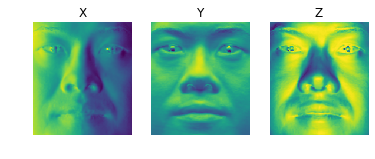

In [28]:
plot_surface_normals(surface_normals)

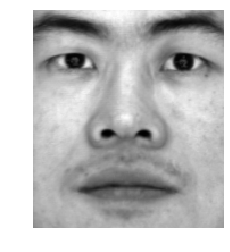

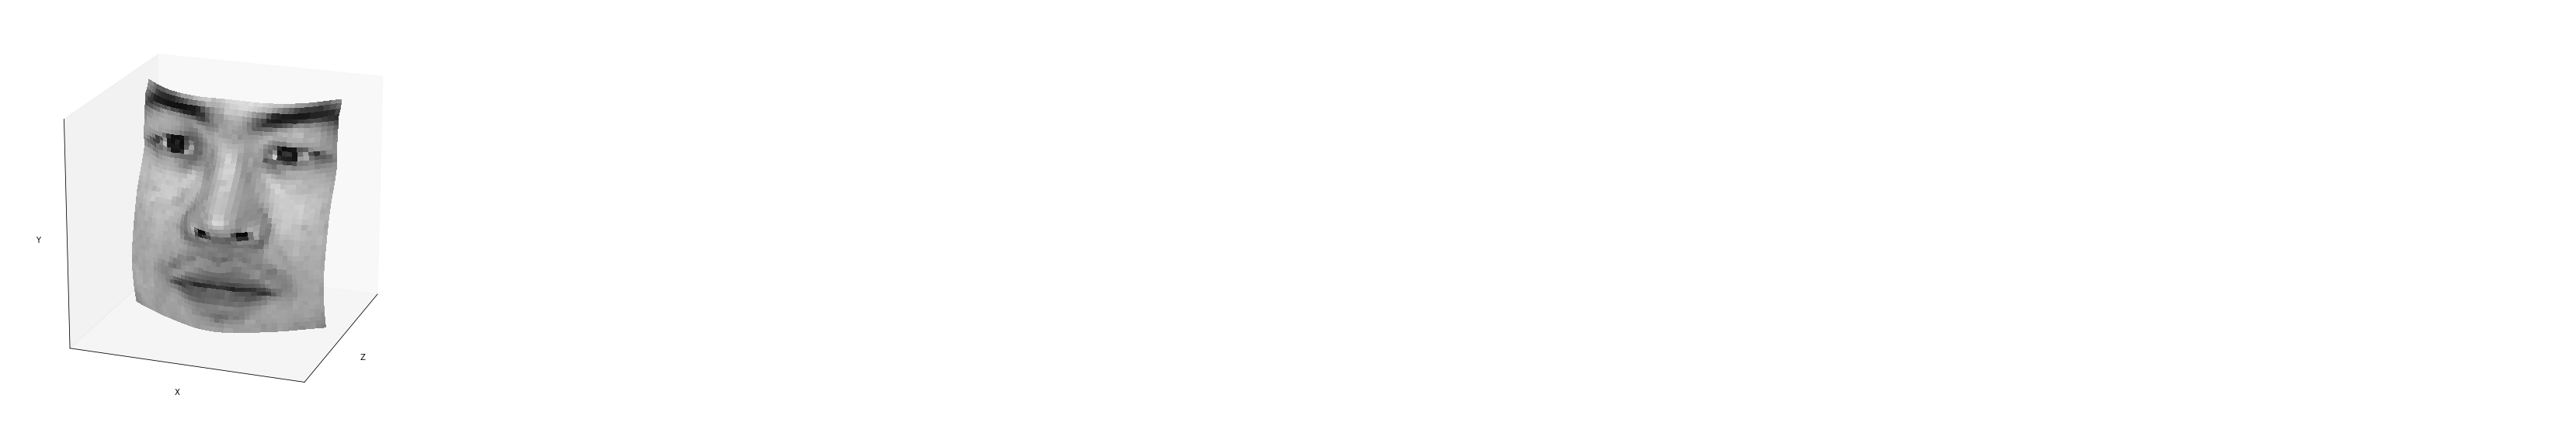

In [29]:
display_output(albedo_image, height_map)

In [30]:
plt.show()